https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html

In [21]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from tqdm.notebook import tqdm 

import tqdm as notebook_tqdm

In [7]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# DATA

In [4]:
# get data
try:
    df = pd.read_csv("../data/AirPassengers.csv", parse_dates=["Month"])
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("AirPassengers.csv"), parse_dates=["Month"])

In [10]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


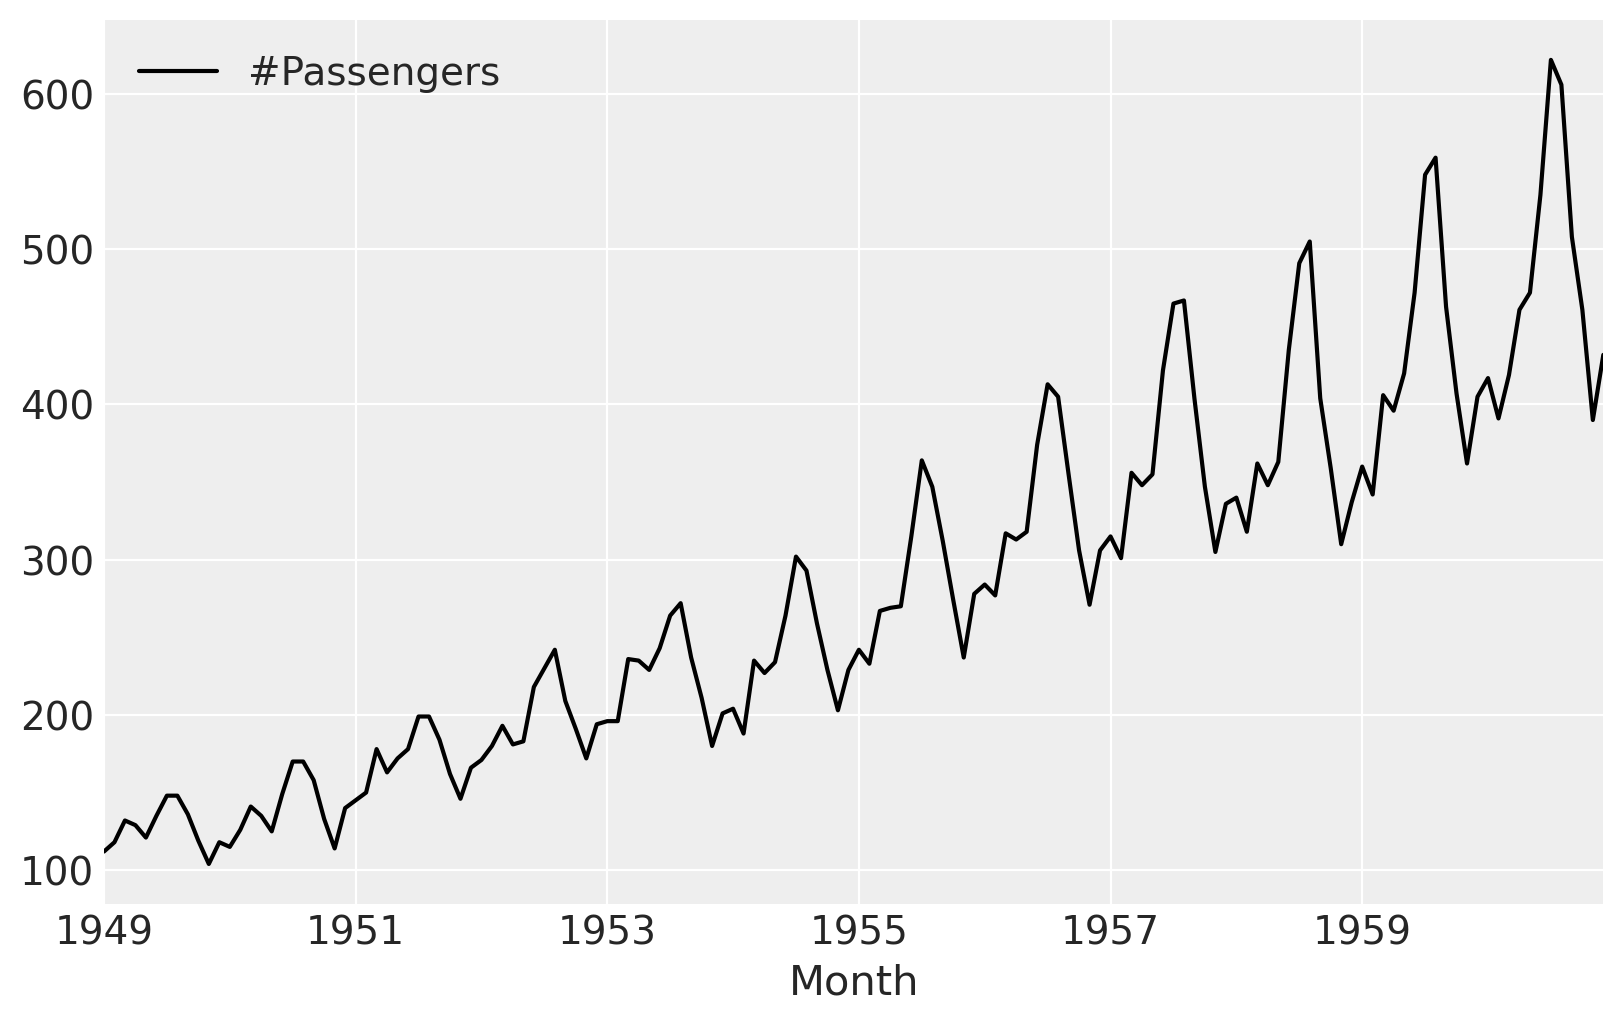

In [9]:
df.plot.line(x="Month", y="#Passengers", color="k");

# Model

## 0 - Scale the data

In [15]:
# Days since 1900-01-01
t = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days.to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [16]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["#Passengers"].to_numpy()
y_max = np.max(y)
y = y / y_max

# 1 - Linear trend

$$
Passengers \sim alpha + \beta \times time
$$

First, let’s try using the default priors set by prophet, and we’ll do a prior predictive check:

Sampling: [likelihood, α, β, σ]
C:\Users\migue\AppData\Local\Temp\ipykernel_27380\2038970584.py:14: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
C:\Users\migue\AppData\Local\Temp\ipykernel_27380\2038970584.py:24: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,


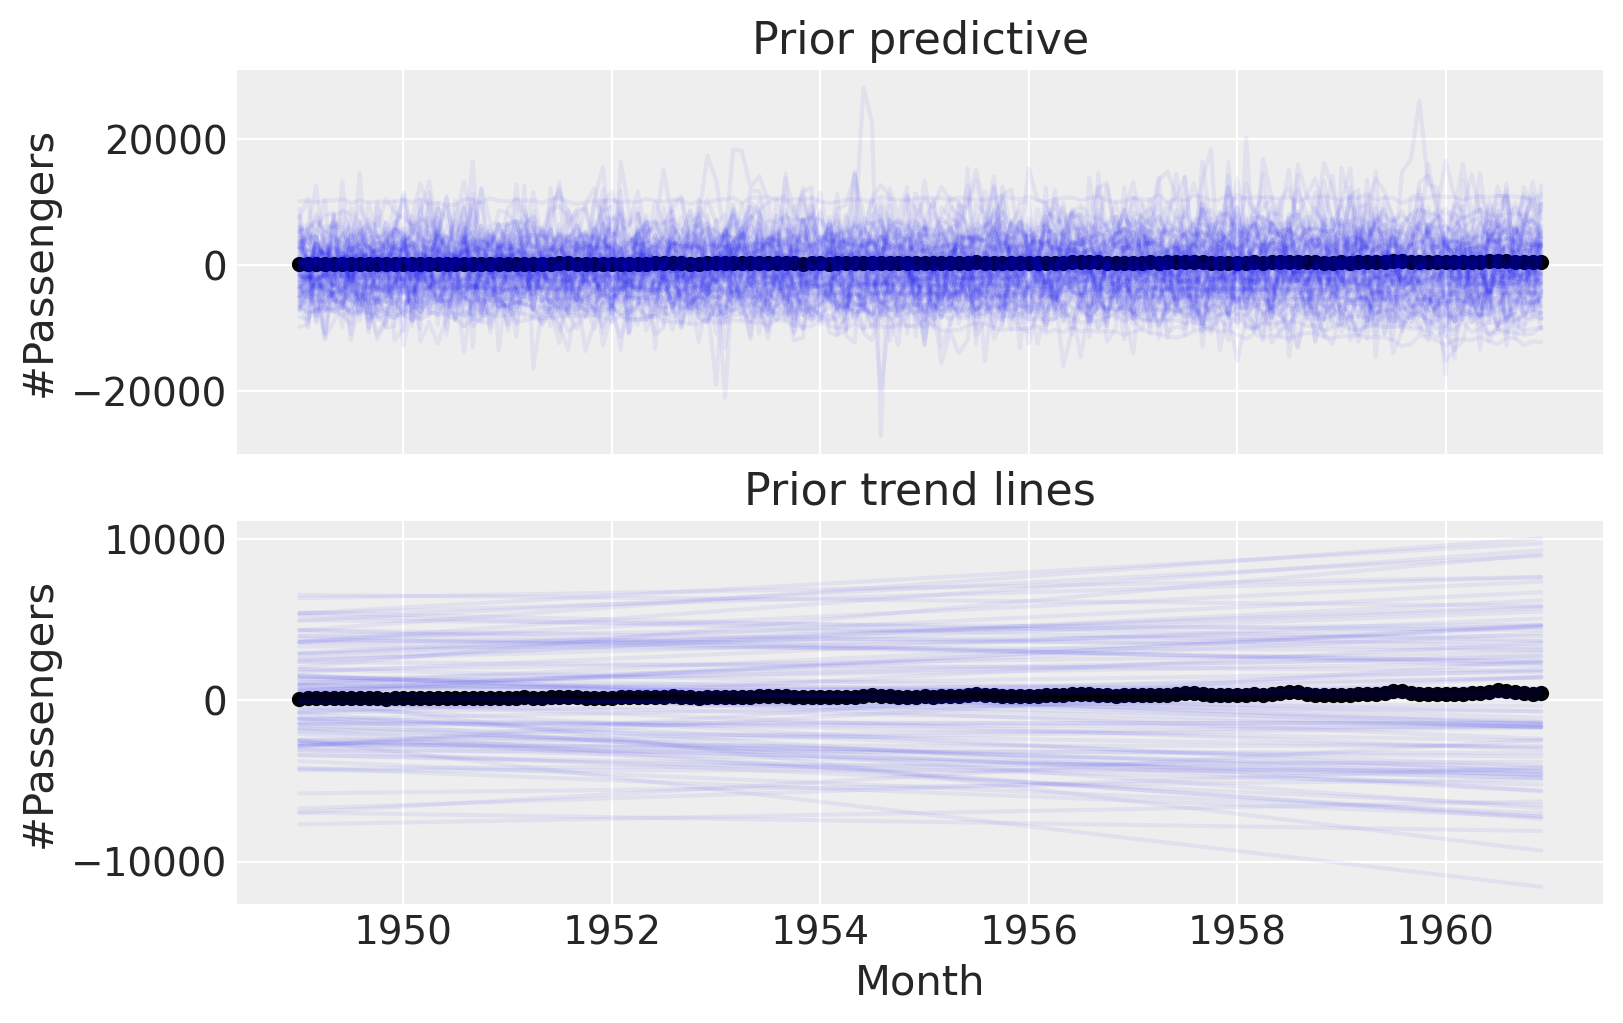

In [17]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

We can do better than this. These priors are evidently too wide, as we end up with implausibly many passengers. Let’s try setting tighter priors.

Sampling: [likelihood, α, β, σ]
C:\Users\migue\AppData\Local\Temp\ipykernel_27380\569887546.py:14: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
C:\Users\migue\AppData\Local\Temp\ipykernel_27380\569887546.py:24: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,


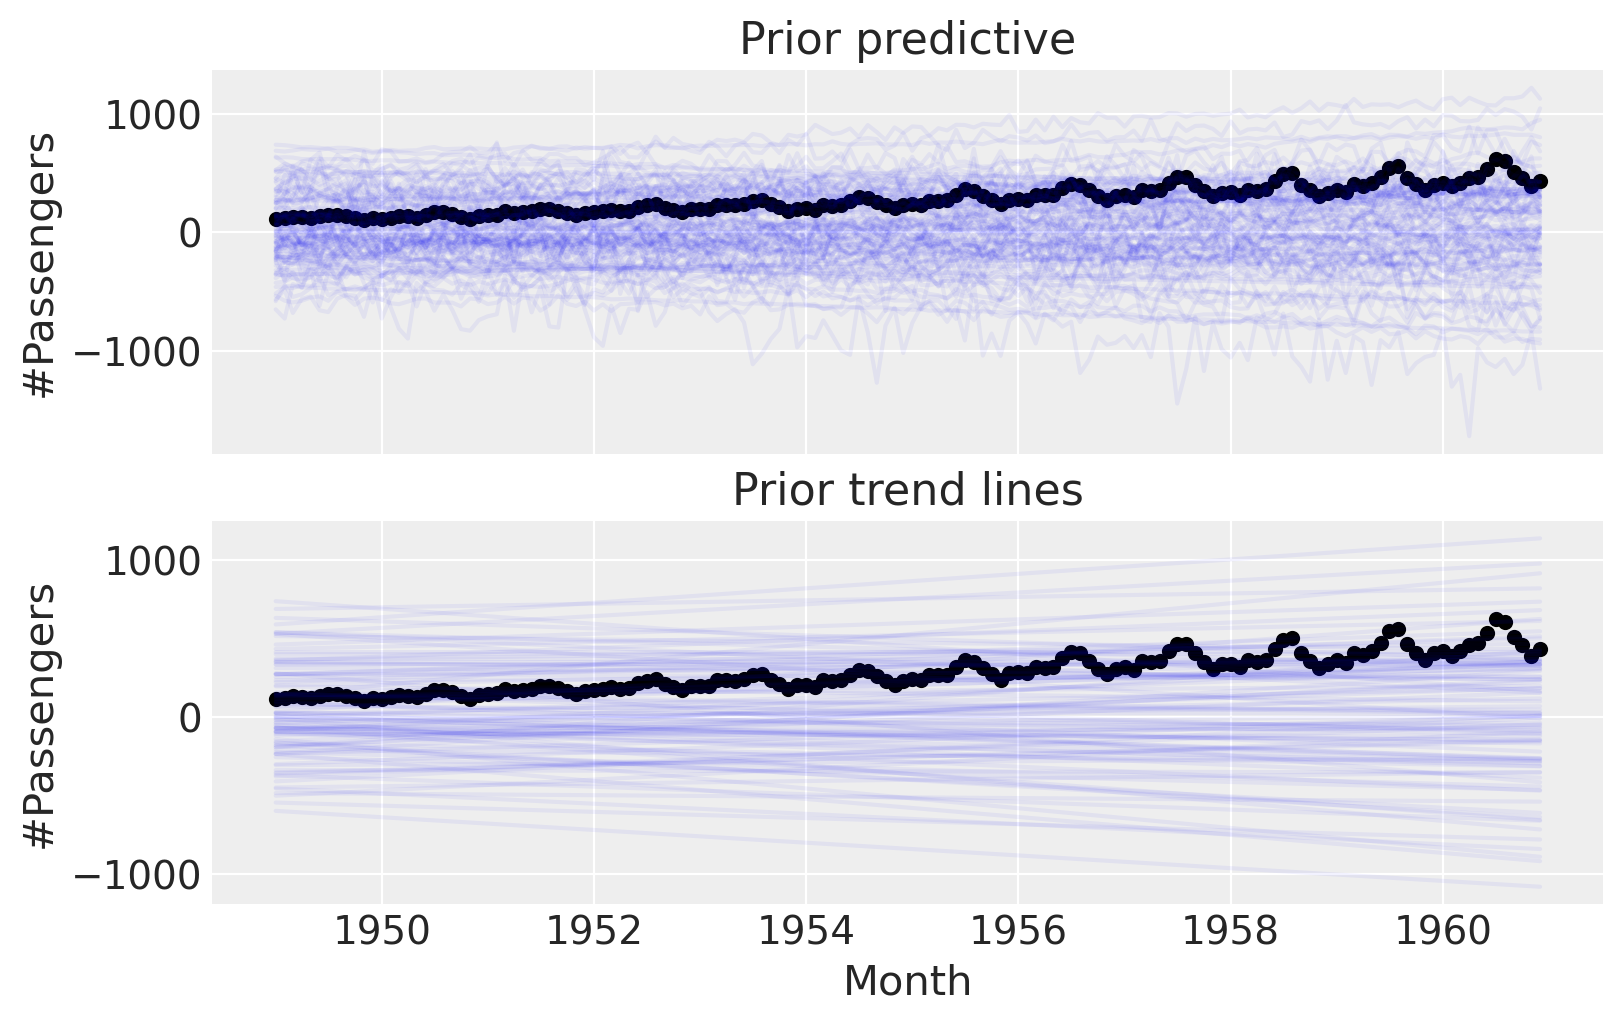

In [18]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior = pm.sample_prior_predictive(samples=100)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="prior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

Cool. Before going on to anything more complicated, let’s try conditioning on the data and doing a posterior predictive check:

Compiling...
Compilation time = 0:00:01.658558
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:04<00:00, 451.73it/s]
Sampling time = 0:00:04.613495
Transforming variables...
Transformation time = 0:00:00.124779
Sampling: [likelihood]


C:\Users\migue\AppData\Local\Temp\ipykernel_27380\1657308408.py:9: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
C:\Users\migue\AppData\Local\Temp\ipykernel_27380\1657308408.py:19: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,


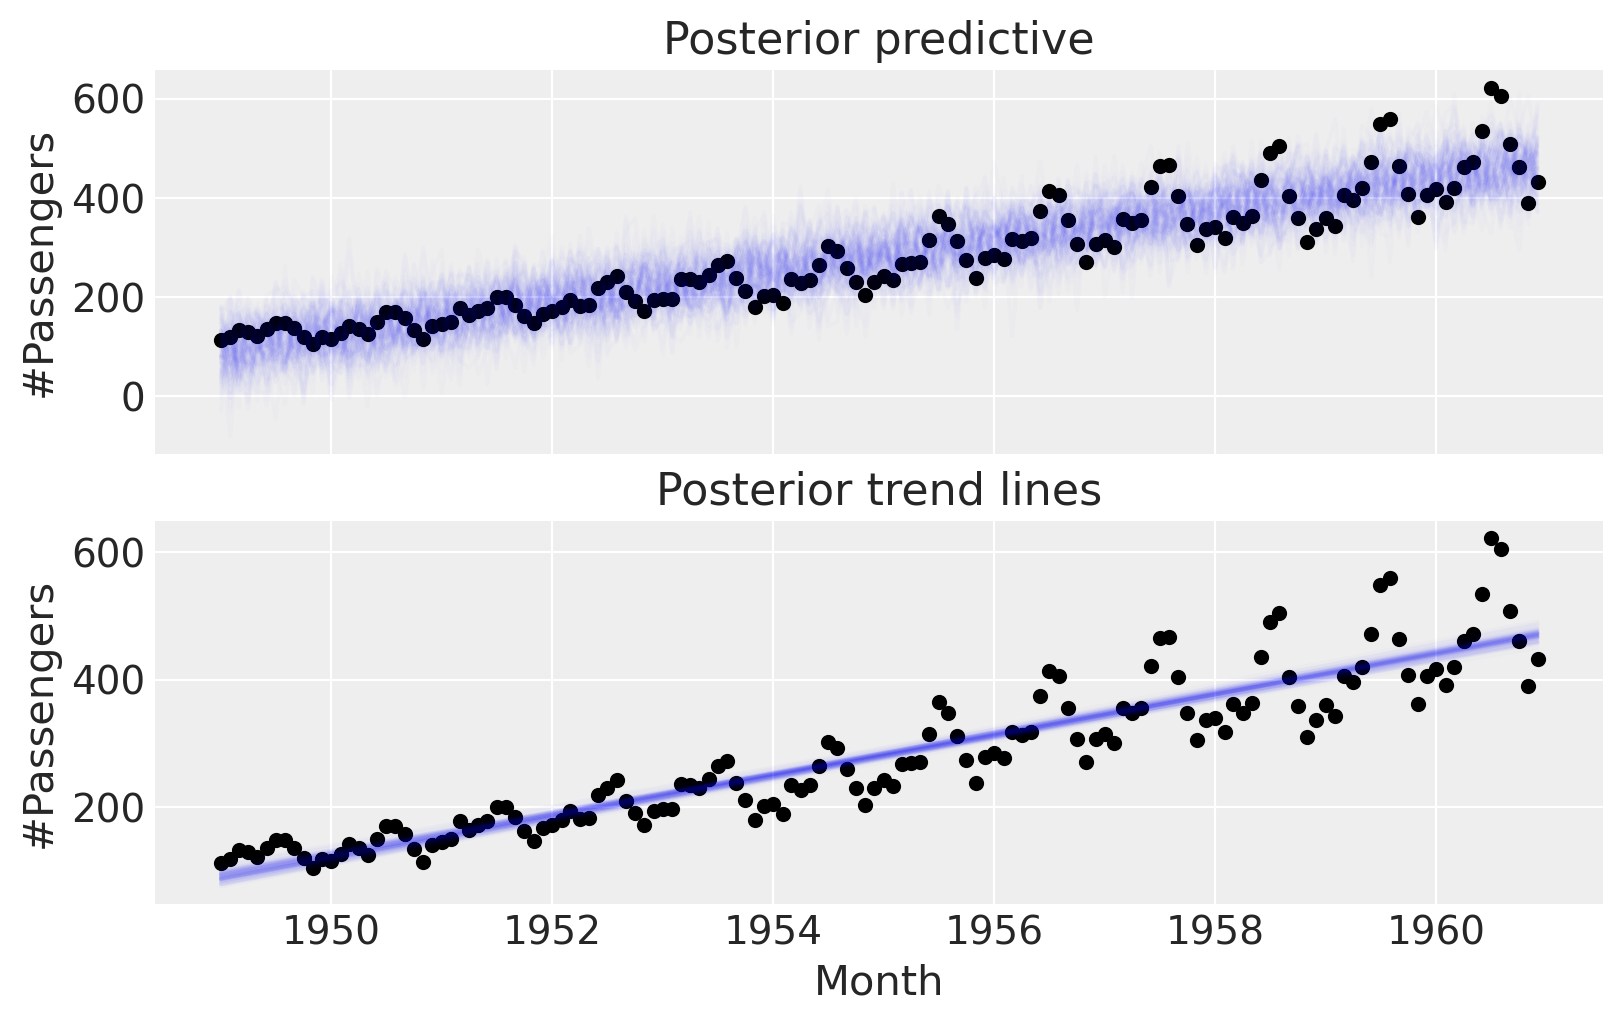

In [22]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True, nuts_sampler='numpyro')
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["Month"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["likelihood"]
    * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["Month"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");